In [1]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from CAP11NA import CAP11NA
from BM1422 import BM1422
from plotAll import generateActiveList

In [2]:
import random
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt

In [3]:
duration = 100

# `Temperature Sensor Configurations`

(Parameters for TMP117 to be changed by teams)  

### `Continuous conversion (if selected) params`:
Continuous conversion mode: The device continuously performs temperature conversions in this mode, as shown in Table 7-7, and updates the temperature result register at the end of every active conversion. 
* Possible conversion cycle times (see Table 7-7 below): 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
* Possible averaging inputs: 0, 8, 32, 64

### `One-Shot conversion (if selected) params`:
One-shot mode: After the device completes a (temperature conversion) one-shot conversion, the device goes to the low-power shutdown mode. 
* Possible conversion cycle times (first row of Table 7-7): 0.0155, 0.125, 0.5, 1 (conv cycle only consists of active time)
* Possible averaging inputs: 0, 8, 32, 64

<img src='convTimes.png' width="700" height="200">


#### TO-DO (teams set inputs)

In [29]:
time_step = 0.0155
activeTimeParams = [(0, 15, "OS_8_0.0155"), (30, 45, "CC_32_16"), (70, 75, "OS_64_16"), (75,100, "OS_8_0.0155")]

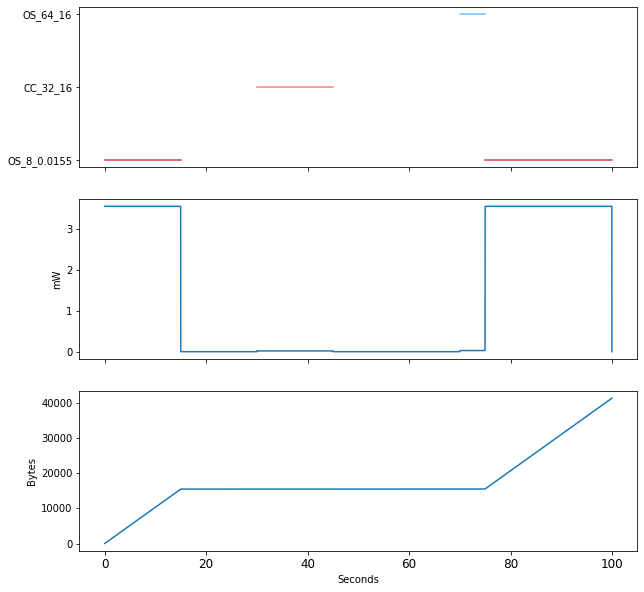

In [30]:
tmp1 = TMP117(time_step, duration, activeTimeParams) # creating TMP117 class
power_tmp, data_tmp, time_tmp = tmp1.Simulation()
tmp1.plotData(power_tmp, data_tmp, time_tmp, activeTimeParams)

In [6]:
modedict = {"OS_16_0.0155": 15, "CC_16_0.0155":30}
activeTimeParams = generateActiveList(duration, modedict=modedict)
tmp2 = TMP117(time_step, duration, activeTimeParams)
tmp2.Simulation();

# `Accelerometer Configurations`

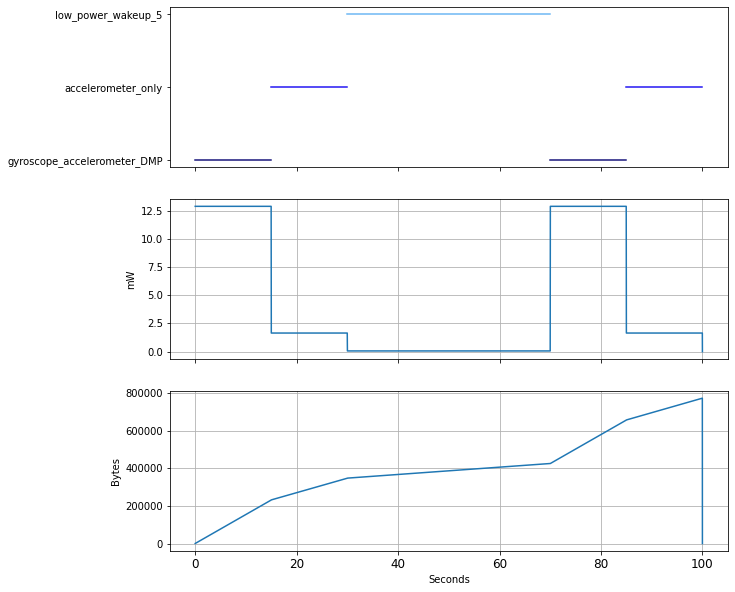

In [7]:
modedict = {"gyroscope_accelerometer_DMP":15, "accelerometer_only":15,"low_power_wakeup_5":40}
active_times = generateActiveList(total_time=100, modedict=modedict)
accel2 = MPU6050(time_step=0.0155, duration=duration, loop_rate=20, digital_low_pass=0, sample_rate_divisor=0)

time_acc, power_acc, data_acc = accel2.runSim(active_times)

# `Thermopile Configurations`

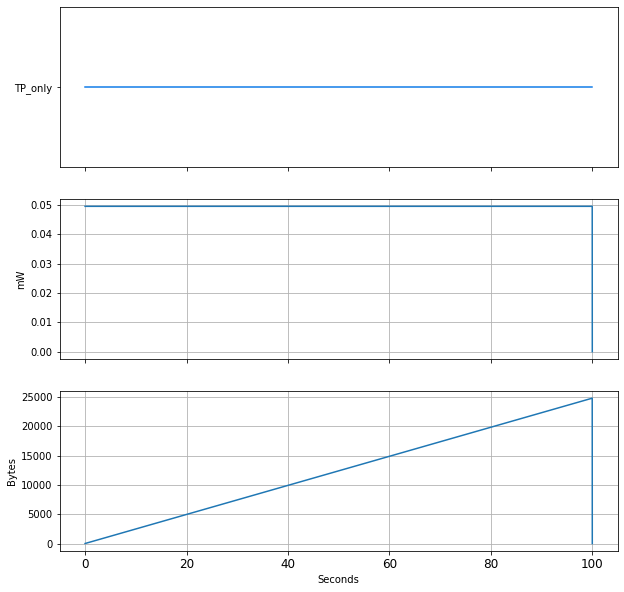

1

In [20]:
from TP import TP
Thermo = TP(time_step=0.0155, duration=duration, loop_rate=20)
active_times = [(0,100,"TP_only")]
Thermo.runSim(active_times)

# `Capacitor Configurations`

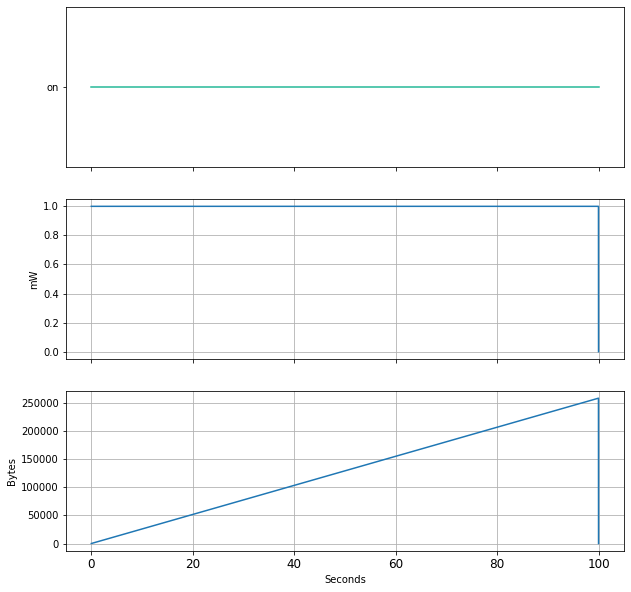

[1 1 1 ... 1 1 0]


In [13]:
cap = CAP11NA(loop_rate=20, duration=duration, time_step=time_step)
cap_active_times = [(0,100,"on")]
cap_time, cap_power, cap_data = cap.runSim(cap_active_times)
print(cap_power)

# `Magnetometer Configurations`

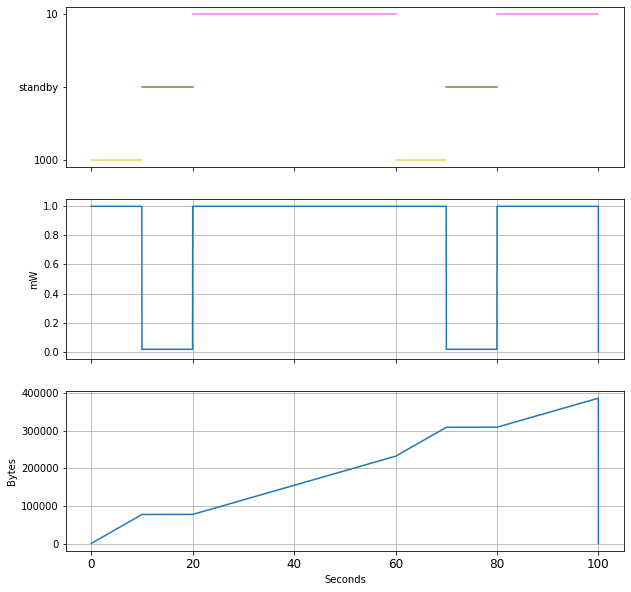

In [ ]:
foo = BM1422(loop_rate=20, duration=duration, time_step=0.0155)
#for magnetometer, the certain mode is the timing specification, or standby.
modedict = {"1000":10, "standby":10,"10":40}
mag_activetimes = generateActiveList(total_time=duration, modedict=modedict)
mag_time, mag_power, mag_data = foo.runSim(mag_activetimes)

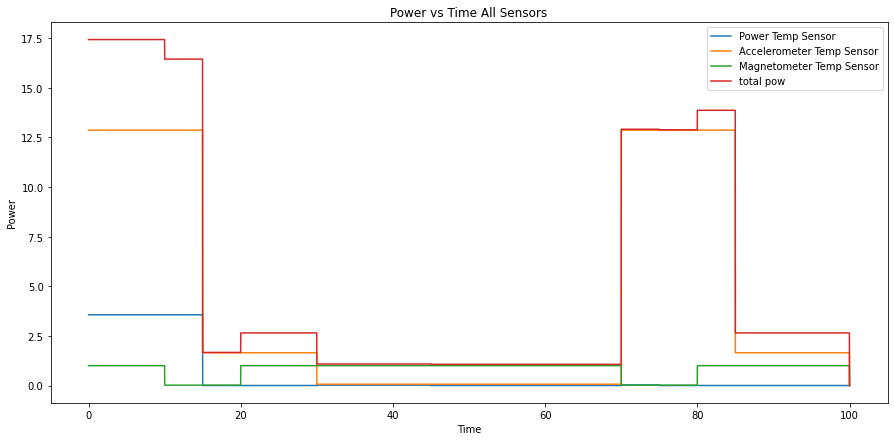

In [ ]:
#plotAll()
plt.figure(figsize=(15, 7))

plt.plot(time_tmp, power_tmp, label = "Power Temp Sensor")
plt.plot(time_acc, power_acc, label = "Accelerometer Temp Sensor")
plt.plot(mag_time, mag_power, label = "Magnetometer Temp Sensor")


total_pow2 = power_tmp + mag_power + power_acc
plt.plot(mag_time, total_pow2, label = "total pow")

#plt.plot(time_thermo, power_thermo)
plt.xlabel("Time")
plt.ylabel("Power")
plt.title("Power vs Time All Sensors")
plt.legend();

In [ ]:
print(total_pow)

NameError: name 'total_pow' is not defined